# 2. Simple homography calculation
- Get manual correspondences (no outlier)
- Implement direct linear transform solver to compute homography

In [28]:
import cv2
import numpy as np
from PIL import Image

from ipywidgets import Label, Button, HBox
from ipycanvas import MultiCanvas, hold_canvas


In [38]:
# Input images
img_filename = 'data/book_desk.jpg'

height, width = cv2.imread(img_filename).shape[:2]
clicked_positions = []


def set_image():
    image = cv2.imread(img_filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    canvas[0].clear()
    canvas[0].put_image_data(image, 0, 0)
    canvas[0].flush()

    if len(clicked_positions):
        handle_mouse_down(clicked_positions[0][0], clicked_positions[0][1])

def handle_mouse_move(xpos, ypos):
    with hold_canvas():
        canvas[1].clear()  # Clear the old animation step
        canvas[1].fill_style = "yellow"
        canvas[1].fill_circle(xpos, ypos, 5)  # Draw the new frame

def handle_mouse_down(xpos, ypos):
    with hold_canvas():
        # canvas[2].clear()
        canvas[2].fill_style = "red"
        canvas[2].fill_circle(xpos, ypos, 5)  # Draw the new frame

    print('click location: (x, y) = ({}, {})'.format(xpos, ypos))
    clicked_positions.append((xpos, ypos))

def handle_clear_button(b):
    canvas[1].clear()
    canvas[2].clear()
    clicked_positions = []

canvas = MultiCanvas(3, width=width, height=height)
cur_fname = Label(value='', disabled=False)
cur_pos = Label(value='', disabled=True)
clear_btn = Button(description='Clear', icon='check')

set_image()
canvas.on_mouse_move(handle_mouse_move)
canvas.on_mouse_down(handle_mouse_down)
clear_btn.on_click(handle_clear_button)

display(canvas, HBox([cur_fname, cur_pos]), HBox([clear_btn]))

MultiCanvas(height=548, width=411)

click location: (x, y) = (188.20000076293945, 120.19970703125)
click location: (x, y) = (29.200000762939453, 295.19970703125)
click location: (x, y) = (271.20000076293945, 409.19970703125)
click location: (x, y) = (366.20000076293945, 171.19970703125)


In [39]:
clicked_positions

[(188.20000076293945, 120.19970703125),
 (29.200000762939453, 295.19970703125),
 (271.20000076293945, 409.19970703125),
 (366.20000076293945, 171.19970703125)]

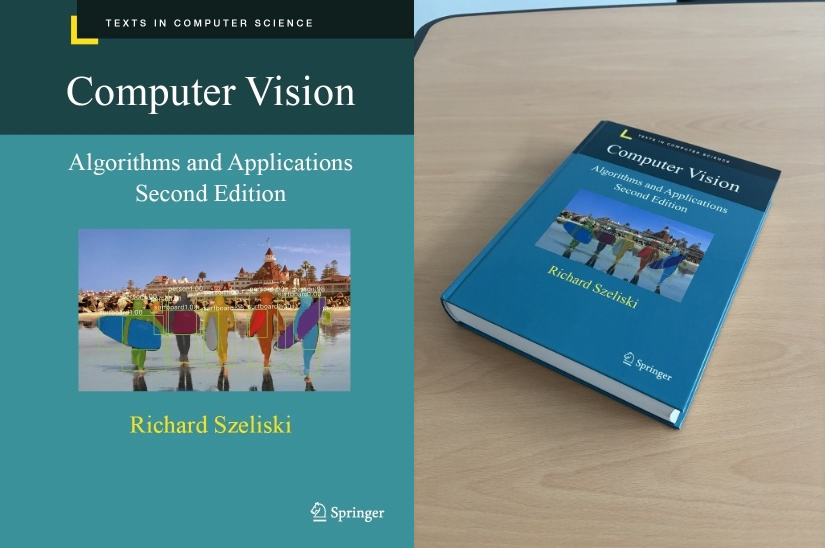

In [40]:
I1 = cv2.imread('data/book_cover.jpg')
I2 = cv2.imread('data/book_desk.jpg')

display(Image.fromarray(np.hstack([I1, I2])[:,:,(2,1,0)]))

In [41]:
h, w, _ = I1.shape
x1 = np.float32([
    [0,     0],
    [0,   h-1],
    [w-1, h-1],
    [w-1,   0],
])

x2 = np.array(clicked_positions[-4:])


In [42]:
def computeH(x1, x2):
    """Compute the homography between two sets of points"""

    assert x1.shape[0] == x2.shape[0], "The number of input and output points mismatches"

    if x1.shape[1] == 2:
        p1 = np.ones((len(x1),3),'float64')
        p1[:,:2] = x1
    elif x1.shape[1] == 3:
        p1 = x1
    else:
        raise ValueError("Bad shape for input points")

    if x2.shape[1] == 2:
        p2 = np.ones((len(x2),3),'float64')
        p2[:,:2] = x2
    elif x2.shape[1] == 3:
        p2 = x2
    else:
        raise ValueError("Bad shape for output points")

    npoints = len(x1)

    A = np.zeros((2 * npoints, 9),'float64')

    for i in range(npoints):
        xsi, ysi, wsi = p1[i]
        xdi, ydi, wdi = p2[i]

        # [TODO] Complete the matrix A
        A[i*2  ,0:3] = [-xsi, -ysi, -wsi]
        A[i*2  ,6  ] = xsi * xdi
        A[i*2  ,7  ] = ysi * xdi
        A[i*2  ,8  ] = wsi * xdi

        A[i*2+1,3:6] = [-xsi, -ysi, -wsi]
        A[i*2+1,6  ] = xsi * ydi
        A[i*2+1,7  ] = ysi * ydi
        A[i*2+1,8  ] = wsi * ydi

    U, S, Vh = np.linalg.svd(A)
    h = Vh[-1]
    H = h.reshape(3,3)
    return H

In [43]:
H = computeH(x1, x2)

In [45]:
# Apply homography

# [TODO] Convert x1 to homogeneous coordinates
x1_homogeneous = np.hstack((x1, np.ones((x1.shape[0], 1))))

# [TODO] Apply homography
x1_prime_homogeneous = np.dot(H, x1_homogeneous.T)
x1_prime_homogeneous = x1_prime_homogeneous.T

# [TODO] Normalize the coordinates
x1_prime = x1_prime_homogeneous[:, :2] / x1_prime_homogeneous[:, 2][:, np.newaxis]

x1_cv = x1.reshape(-1, 1, 2)
x1_prime_cv = x1_prime.reshape(-1, 1, 2)

I1 = cv2.polylines(I1, [np.int32(x1_cv)], True, 255, 2, cv2.LINE_AA)
I2 = cv2.polylines(I2, [np.int32(x1_prime_cv)], True, 255, 2, cv2.LINE_AA)

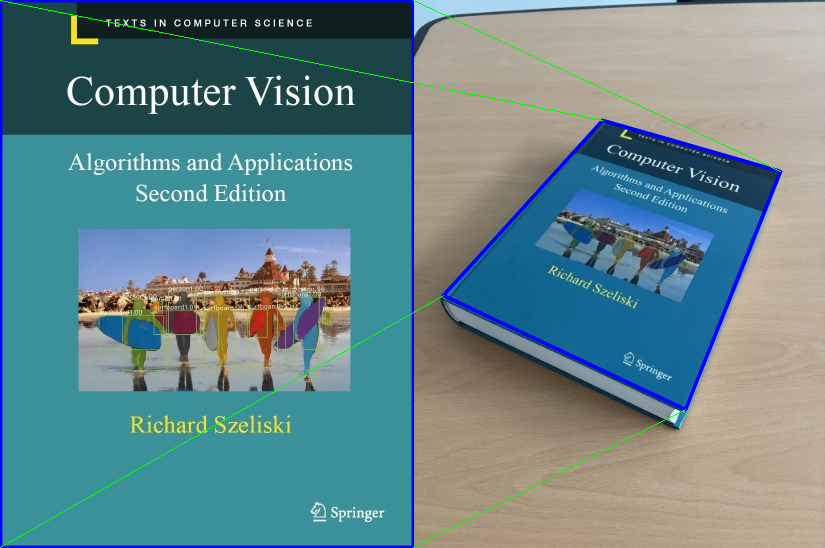

In [46]:
images = np.hstack([I1, I2])

for x1_i, x1_prime_i in zip(x1.astype(np.int32), x1_prime.astype(np.int32)):
    x1_prime_i[0] += w
    cv2.line(images, x1_i, x1_prime_i, (0, 255, 0), 1)

display(Image.fromarray(images[:,:,(2,1,0)]))